1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


(array([  2.,   3.,   2.,   2.,   2.,   2.,  11.,   6.,   6.,   6.,  14.,
          9.,  10.,   5.,   3.,   8.,   5.,   1.,   1.,   2.]),
 array([-0.25283131, -0.22955778, -0.20628424, -0.18301071, -0.15973718,
        -0.13646365, -0.11319012, -0.08991659, -0.06664306, -0.04336952,
        -0.02009599,  0.00317754,  0.02645107,  0.0497246 ,  0.07299813,
         0.09627166,  0.1195452 ,  0.14281873,  0.16609226,  0.18936579,
         0.21263932]),
 <a list of 20 Patch objects>)

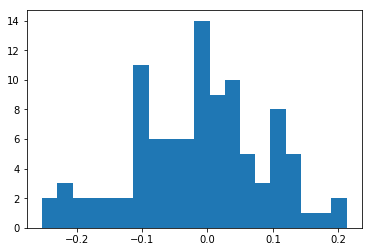

In [103]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
mean=0
N=100
std=0.1
X=np.random.normal(u,std,N)
plt.hist(X,bins=20) 


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

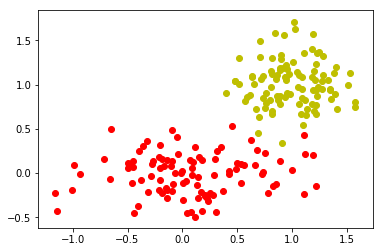

In [104]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
#from IPython.display import Image
#Image('two_categories_scatter_plot.png')
u=0
std=0.5
u1=1
std1=0.25
X=np.random.normal(u,std,100)
Y=np.random.normal(u,std1,100)

X1=np.random.normal(u1,std1,100)
Y1=np.random.normal(u1,std1,100)
plt.scatter(X,Y, marker='o', c='r')
plt.scatter(X1,Y1,marker='o', c='y')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

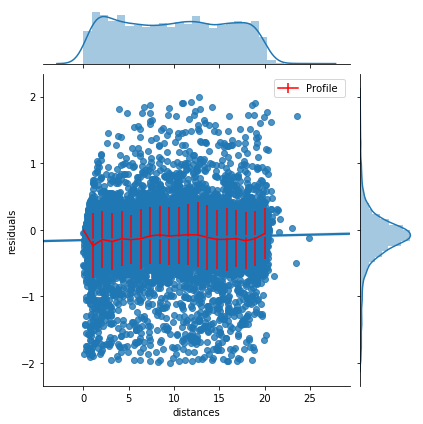

In [106]:
import pandas as pd
import seaborn as sns
import scipy 
from scipy import stats
data =np.load('residuals_261.npy').item()
df=pd.DataFrame(data)
df

df = df[abs(df['residuals']) < 2]
slope, intercept, r_value, p_value, std_err=scipy.stats.linregress(df['distances'],df['residuals'])

###### Linear regression plot
#slope, intercept, r_value, p_value, std_err=scipy.stats.linregress(df['distances'],df['residuals'])
#plt.plot(df['distances'],df['residuals'], 'o', label='original data')
#plt.plot(df['distances'], intercept + slope*df['distances'], 'r', label='fitted line')
#plt.legend()
#plt.show()

####### linear regression plot with SEABORN
#sns.regplot(x="distances", y="residuals", data=df);

####### SEABORN Jointplot
sns.jointplot(df['distances'], df['residuals'], kind='reg')

x = np.linspace(0,20,20)

erry=[]
y = []
y.append(0)
erry.append(0)

for i in x[1:]:
    new=df[df['distances']<i]
    df=df[df['distances']>=[i]]
    
    y.append(new['residuals'].mean())
    erry.append(new['residuals'].std())
    
    
    

plt.errorbar(x,y,yerr=erry, color='red', label='Profile ')
plt.legend()